# 프로젝트: CAM을 만들고 평가해 보자


## CAM 구현하기
## Grad-CAM 구현하기
## guided Grad-CAM 구현하기(보완필요)
## 바운딩 박스 구하기
## IoU 구하기

## 추가실험1. 레이어별 활성화 채널 시각화
## 추가실험2. ACL 모델 구현(보완필요)

## 루브릭

아래의 기준을 바탕으로 프로젝트를 평가합니다.


1. CAM을 얻기 위한 기본모델의 구성과 학습이 정상 진행되었는가?	
ResNet50 + GAP + DenseLayer 결합된 CAM 모델의 학습과정이 안정적으로 수렴하였다.

2. 분류근거를 설명 가능한 Class activation map을 얻을 수 있는가?	
CAM 방식과 Grad-CAM 방식의 class activation map이 정상적으로 얻어지며, 시각화하였을 때 해당 object의 주요 특징 위치를 잘 반영한다.


3. 인식결과의 시각화 및 성능 분석을 적절히 수행하였는가?	
CAM과 Grad-CAM 각각에 대해 원본이미지합성, 바운딩박스, IoU 계산 과정을 통해 CAM과 Grad-CAM의 object localization 성능이 비교분석되었다.

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=False,  # 파일 셔플 비활성화
    with_info=True,
)
print("Dataset loaded successfully.")



Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.
Dataset loaded successfully.


In [4]:
# 고정된 시드로 셔플하는 함수
def shuffle_with_fixed_seed(ds, seed=42):
    """
    고정된 시드를 사용해 데이터셋을 셔플.
    Args:
        ds (tf.data.Dataset): 입력 데이터셋.
        seed (int): 셔플에 사용할 시드 값.
    Returns:
        tf.data.Dataset: 고정 시드로 셔플된 데이터셋.
    """
    ds = ds.enumerate()  # 인덱스를 추가
    ds = ds.shuffle(buffer_size=1000, seed=seed)  # 고정된 시드로 셔플
    ds = ds.map(lambda idx, item: item)  # 인덱스를 제거하고 원본 데이터 반환
    return ds

# 학습 세트에만 셔플 적용
ds_train = shuffle_with_fixed_seed(ds_train, seed=42)  # 고정된 시드로 셔플

# 테스트 세트는 셔플 없이 그대로 사용
ds_test =shuffle_with_fixed_seed(ds_test, seed=42)  # 고정된 시드로 셔플


print("Data processing complete. Training and test sets are ready.")


Data processing complete. Training and test sets are ready.


In [26]:
# 2. 데이터셋 구조 확인 (Optional)
print("Train Dataset Spec:", ds_train.element_spec)
print("Test Dataset Spec:", ds_test.element_spec)


Train Dataset Spec: {'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)}}
Test Dataset Spec: {'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'objects': {'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)}}


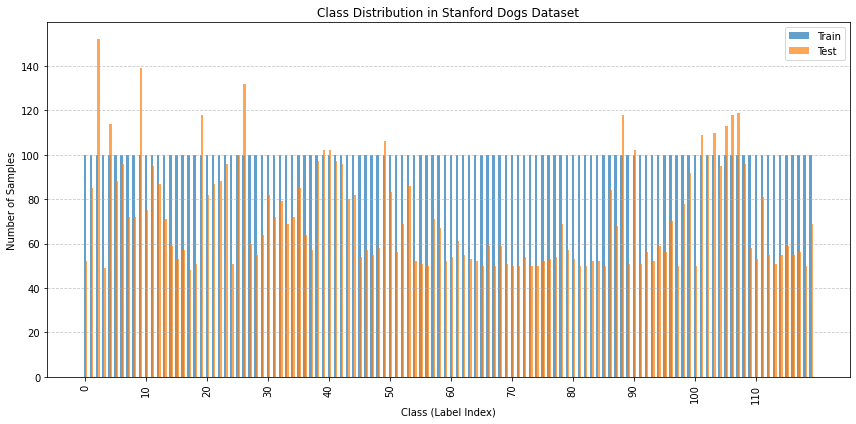

In [27]:
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter

# 3. 클래스 분포를 추출하는 함수 정의
def get_class_distribution(dataset):
    labels = []
    for element in tfds.as_numpy(dataset):
        # 딕셔너리 구조에서 label 추출
        label = element['label']
        labels.append(label)
    return Counter(labels)

# 4. 클래스 분포 계산
train_distribution = get_class_distribution(ds_train)
test_distribution = get_class_distribution(ds_test)

# 5. 정렬된 클래스별 분포 계산
train_classes = sorted(train_distribution.keys())
train_counts = [train_distribution[c] for c in train_classes]
test_classes = sorted(test_distribution.keys())
test_counts = [test_distribution[c] for c in test_classes]

# 6. 분포 시각화
plt.figure(figsize=(12, 6))

# Training 데이터 분포
plt.bar(train_classes, train_counts, alpha=0.7, label="Train", width=0.4, align='center')

# Test 데이터 분포
plt.bar(test_classes, test_counts, alpha=0.7, label="Test", width=0.4, align='edge')

# 그래프 설정
plt.title("Class Distribution in Stanford Dogs Dataset")
plt.xlabel("Class (Label Index)")
plt.ylabel("Number of Samples")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.xticks(range(0, len(train_classes), 10), rotation=90)  # 클래스 간격 설정

plt.tight_layout()
plt.show()

각 이미지의 클래스와 그 인덱스(index)를 확인

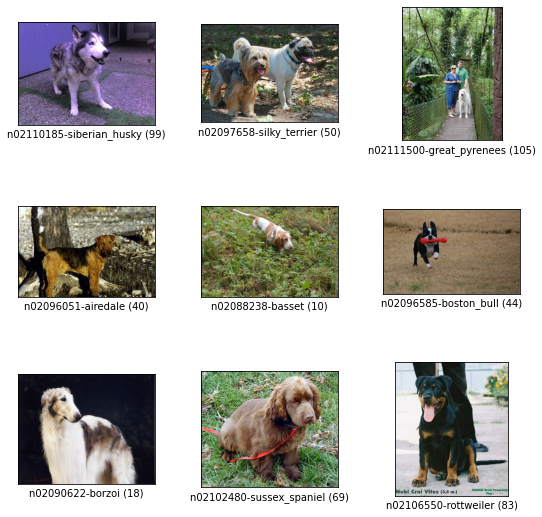

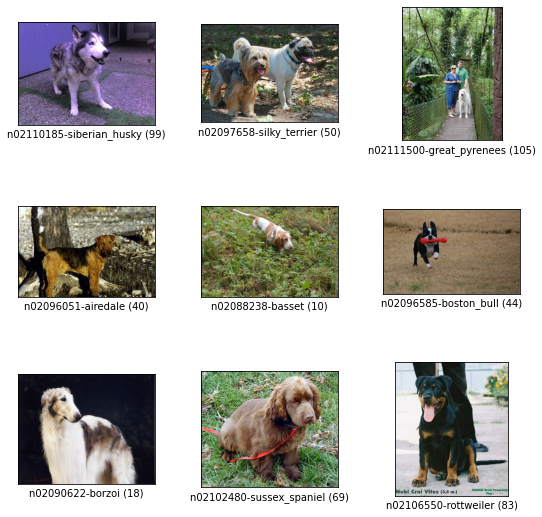

In [28]:
tfds.show_examples(ds_train, ds_info)

평가용 데이터도 확인

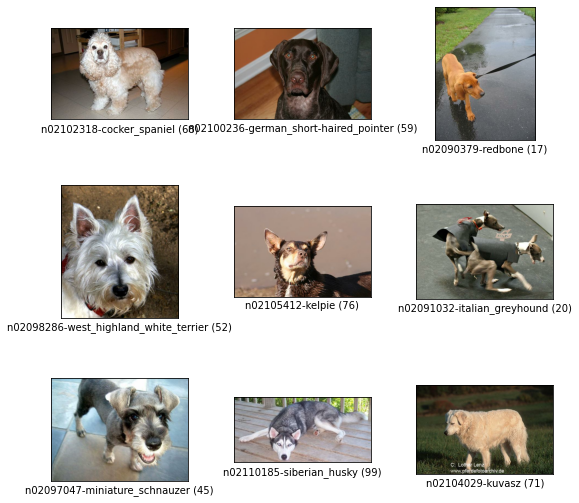

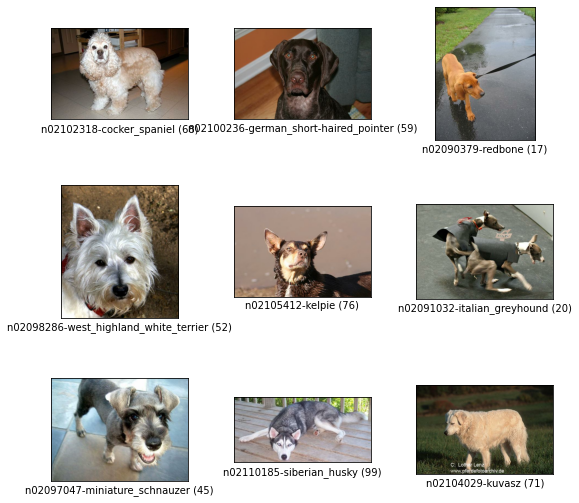

In [29]:
tfds.show_examples(ds_test, ds_info)

데이터셋의 메타 정보인 df_info를 조회해 features가 어떻게 구성되어 있는지 확인

In [30]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=120),
    'objects': Sequence({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
    }),
})

CAM, Grad-CAM용 모델 준비하기 (3) CAM을 위한 모델 만들기

ResNet50 뒤에 필요한 레이어를 붙여 CAM을 구하기 위한 기본 모델을 완성

In [37]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 데이터셋 클래스 수
num_classes = ds_info.features["label"].num_classes

# ResNet50 기반 모델 생성 (Feature Extractor)
base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Fully Connected Layer 제거
    weights='imagenet',   # Pretrained weights 사용
    input_shape=(224, 224, 3),  
    pooling='avg'         # Global Average Pooling (GAP) 적용
)

# Feature Extractor 출력
x = base_model.output  

# Dense Layer 추가 (클래스 수에 맞춤)
preds = layers.Dense(num_classes, activation='softmax', name="predictions")(x)

# CAM 모델 정의
camtest_model = keras.Model(inputs=base_model.input, outputs=preds)


### 모델 요약
 입력 이미지 → Conv 레이어 → 풀링 → Residual 블록 → 글로벌 풀링 → Fully Connected 레이어

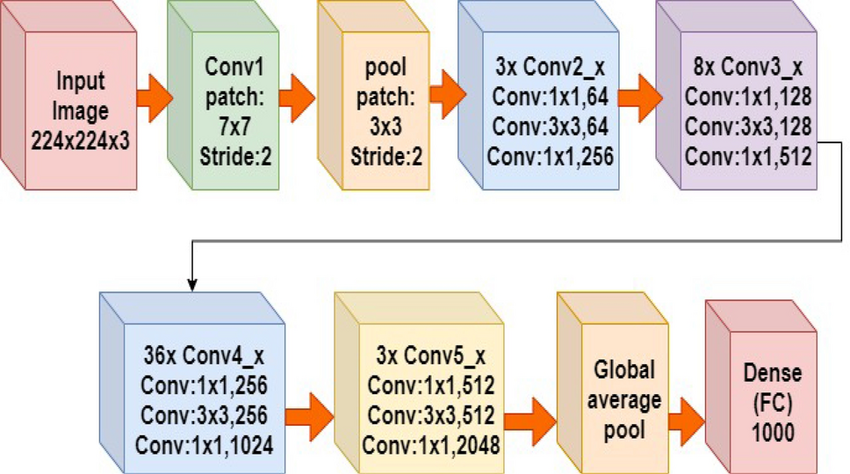

In [38]:
camtest_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

normalizing과 resizing을 포함한 간단한 전처리

In [39]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('슝=3')

슝=3


In [40]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


 학습

In [41]:
camtest_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

print('슝=3')

슝=3


기존 챕터 학습모델 가져와 사용하려 하였으나 실패

모델 출력 크기 ((None, 120))

모델의 출력이 (None, 120)으로, 120개의 클래스를 가진 원-핫 인코딩(One-Hot Encoding) 형태로 예측값을 출력하고 있음.
레이블 크기 ((None, 1))

데이터셋에서 제공되는 레이블이 (None, 1)로, 정수형 클래스 인덱스(Integer Label)로 저장되어 있음.
즉, 데이터셋에서 레이블이 원-핫 인코딩되지 않은 상태.

오류의 원인

모델은 categorical_crossentropy 손실 함수를 사용하고 있으며, 이 함수는 원-핫 인코딩된 레이블이 필요
하지만 레이블이 정수형 클래스 인덱스 (None, 1)인 상태에서 손실 함수에 입력


기본 실습에 제공 된 Resnet 모델이용하여 실습하였으나, 테스트 데이터와 훈련데이터가 혼재되어, 이미지 확인식 accuracy 1이라는 결과나옴

확인을 위하여 새롭게 10에폭만 진행

In [17]:
# 모델 저장 시 권한이 문제되어 진행
!chmod 777 ./history

In [42]:
#제공된 모델 사용
import os
import tensorflow as tf

from tensorflow.keras.callbacks import ReduceLROnPlateau

# 체크포인트 경로 설정
checkpoint_path = 'history/camtest_model.h5'

# Set paths for loading and saving models
load_path = 'history/camtest_model.h5'
save_path = 'history/camtest_model.h5'


# 기존 모델 불러오기 또는 새 모델 생성
if os.path.exists(load_path):
    print(f"기존 모델 '{load_path}' 로드 중...")
    cam_model = tf.keras.models.load_model(load_path)
else:
    print("기존 모델이 없습니다. 새 모델을 생성합니다.")
    cam_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
        metrics=['accuracy'],
    )

# # 콜백 정의
# callbacks = tf.keras.callbacks.ModelCheckpoint(
#     checkpoint_path,
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True
# )

# # 모델 학습
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=5,
#     validation_data=ds_val_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )



# Callback for saving the best model
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    save_path,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True
)

# Callback for reducing the learning rate
lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Model training
history_camtest_model = camtest_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
    validation_data=ds_val_norm,
    validation_steps=int(ds_info.splits['test'].num_examples / 16),
    epochs=10,
    verbose=1,
    use_multiprocessing=True,
    callbacks=[model_checkpoint, lr_scheduler]
)

기존 모델이 없습니다. 새 모델을 생성합니다.
Epoch 1/10
750/750 [==============================] - 171s 212ms/step - loss: 2.2087 - accuracy: 0.4458 - val_loss: 4.0526 - val_accuracy: 0.1245

Epoch 00001: val_accuracy improved from -inf to 0.12447, saving model to history/camtest_model.h5


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
750/750 [==============================] - 156s 208ms/step - loss: 0.8336 - accuracy: 0.7573 - val_loss: 1.1344 - val_accuracy: 0.6693

Epoch 00002: val_accuracy improved from 0.12447 to 0.66931, saving model to history/camtest_model.h5
Epoch 3/10
750/750 [==============================] - 156s 208ms/step - loss: 0.3922 - accuracy: 0.8962 - val_loss: 1.1563 - val_accuracy: 0.6722

Epoch 00003: val_accuracy improved from 0.66931 to 0.67222, saving model to history/camtest_model.h5
Epoch 4/10
750/750 [==============================] - 155s 207ms/step - loss: 0.1862 - accuracy: 0.9609 - val_loss: 0.9950 - val_accuracy: 0.7155

Epoch 00004: val_accuracy improved from 0.67222 to 0.71549, saving model to history/camtest_model.h5
Epoch 5/10
750/750 [==============================] - 156s 207ms/step - loss: 0.0870 - accuracy: 0.9867 - val_loss: 0.9813 - val_accuracy: 0.7345

Epoch 00005: val_accuracy improved from 0.71549 to 0.73447, saving model to history/camtest_model.h5
Epoch 6/

In [42]:
#권한 문제로 모델 저장되지 않음 

# import os
# import tensorflow as tf

# # 디렉토리 생성
# checkpoint_dir = './history'
# os.makedirs(checkpoint_dir, exist_ok=True)

# # 체크포인트 경로 설정
# checkpoint_path = os.path.join(checkpoint_dir, 'cam_model.h5')

# # ModelCheckpoint 콜백
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
#     filepath=checkpoint_path,
#     monitor='val_loss',
#     verbose=1,
#     save_best_only=True
# )

# # ReduceLROnPlateau 콜백 추가
# lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=3,
#     min_lr=1e-6,
#     verbose=1
# )

# # 모델 학습
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples / 16),
#     validation_data=ds_val_norm,
#     validation_steps=int(ds_info.splits['test'].num_examples / 16),
#     epochs=10,
#     verbose=1,
#     use_multiprocessing=True,
#     callbacks=[model_checkpoint, lr_scheduler]
# )


Epoch 1/10
750/750 [==============================] - 158s 204ms/step - loss: 0.0118 - accuracy: 0.9989 - val_loss: 1.0373 - val_accuracy: 0.7355

Epoch 00001: val_loss improved from inf to 1.03727, saving model to ./history/cam_model.h5


OSError: Unable to create file (unable to open file: name = './history/cam_model.h5', errno = 30, error message = 'Read-only file system', flags = 13, o_flags = 242)

In [38]:
# history_cam_model = cam_model.fit(
#     ds_train_norm,
#     steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
#     validation_steps=int(ds_info.splits['test'].num_examples/16),
#     epochs=10,
#     validation_data=ds_val_norm,
#     verbose=1,
#     use_multiprocessing=True,
# )

Epoch 1/10
750/750 [==============================] - 160s 205ms/step - loss: 2.1939 - accuracy: 0.4536 - val_loss: 3.3072 - val_accuracy: 0.2157
Epoch 2/10
750/750 [==============================] - ETA: 0s - loss: 0.7192 - accuracy: 0.8002

KeyboardInterrupt: 

 '/aiffel/class_activation_map' 에 'camtest_model.h5'을 저장

In [43]:
import os

# 저장 경로 설정
cam_model_path = os.path.join('/aiffel/class_activation_map', 'camtest_model.h5')

# 모델 저장
camtest_model.save(cam_model_path)


학습된 모델을 활용하여 CAM을 생성(커널 재시작 요망)

In [1]:
# # 커널 재시작 이후 실습을 위해, 이전 스텝의 코드를 모아서 한꺼번에 실행합니다.
# import tensorflow as tf
# from tensorflow import keras
# import numpy as np
# import matplotlib.pyplot as plt
# import tensorflow_datasets as tfds
# import copy
# import cv2
# from PIL import Image

# (ds_train, ds_test), ds_info = tfds.load(
#     'stanford_dogs',
#     split=['train', 'test'],
#     shuffle_files=True,
#     with_info=True,
# )

# def normalize_and_resize_img(input):
#     # Normalizes images: `uint8` -> `float32`
#     image = tf.image.resize(input['image'], [224, 224])
#     input['image'] = tf.cast(image, tf.float32) / 255.
#     return input['image'], input['label']

# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
#     ds = ds.map(
#         normalize_and_resize_img, 
#         num_parallel_calls=2
#     )
#     ds = ds.batch(batch_size)
#     '''
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     '''
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

# print('슝=3')

슝=3


In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import copy
import cv2
from PIL import Image

# 데이터셋 로드
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=False,  # 파일 셔플링 비활성화
    with_info=True,
)

# 이미지를 정규화하고 크기 조정
def normalize_and_resize_img(input):
    """
    이미지를 정규화 및 리사이즈하는 함수.
    Args:
        input (dict): 'image', 'label' 키를 포함하는 입력 데이터.

    Returns:
        tuple: 정규화된 이미지와 라벨.
    """
    image = tf.image.resize(input['image'], [224, 224])  # 224x224 크기로 리사이즈
    input['image'] = tf.cast(image, tf.float32) / 255.0  # 정규화
    return input['image'], input['label']

# 고정된 셔플링
def shuffle_with_fixed_seed(ds, seed=42):
    """
    고정된 시드로 데이터셋을 셔플링.
    
    Args:
        ds (tf.data.Dataset): 입력 데이터셋.
        seed (int): 셔플링에 사용할 시드 값.
        
    Returns:
        tf.data.Dataset: 고정된 시드로 셔플된 데이터셋.
    """
    ds = ds.enumerate()  # 데이터에 인덱스를 추가
    ds = ds.shuffle(buffer_size=1000, seed=seed)  # 고정된 시드로 셔플
    ds = ds.map(lambda idx, item: item)  # 인덱스를 제거하고 원본 데이터 반환
    return ds

# 데이터셋에 정규화 및 옵션 적용
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, seed=42):
    """
    데이터셋에 정규화, 배치 처리 및 옵션 적용.
    
    Args:
        ds (tf.data.Dataset): 입력 데이터셋.
        is_test (bool): 테스트 데이터셋 여부.
        batch_size (int): 배치 크기.
        seed (int): 셔플링에 사용할 시드 값.
    
    Returns:
        tf.data.Dataset: 정규화 및 옵션이 적용된 데이터셋.
    """
    ds = ds.map(
        normalize_and_resize_img,
        num_parallel_calls=tf.data.AUTOTUNE  # 병렬 처리 최적화
    )
    if not is_test:
        ds = shuffle_with_fixed_seed(ds, seed=seed)  # 고정된 시드로 셔플링
        ds = ds.repeat()  # 무한 반복 (훈련용)
    ds = ds.batch(batch_size)  # 배치 처리
    ds = ds.prefetch(tf.data.AUTOTUNE)  # 데이터 전처리와 학습 병렬화
    return ds

# 데이터셋 준비
batch_size = 16
seed = 42
ds_train_normalized = apply_normalize_on_dataset(ds_train, is_test=False, batch_size=batch_size, seed=seed)
ds_test_normalized = apply_normalize_on_dataset(ds_test, is_test=True, batch_size=batch_size)

print('슝=3')


슝=3


CAM을 생성
CAM 생성 작업은 데이터셋 배치 단위가 아니라 개별 이미지 데이터 단위로 이루어지기 때문에, get_one() 함수로 데이터셋에서 한 장씩 뽑을 수 있도록함(이미지가 랜덤으로 선택되어, 같은 이미지를 뽑을 수 있는 코드로 변경함)

In [48]:
# def get_one(ds):
#     ds = ds.take(1)
#     sample_data = list(ds.as_numpy_iterator())
#     bbox = sample_data[0]['objects']['bbox']
#     image = sample_data[0]['image']
#     label = sample_data[0]['label']
#     return sample_data[0]

# print('슝=3')

슝=3


100


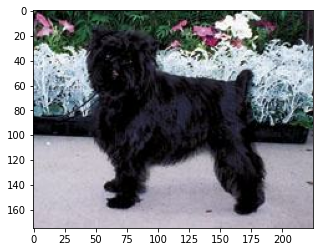

In [3]:
# item = get_one(ds_test)
# print(item['label'])
# plt.imshow(item['image'])
# plt.show()

모든 실험에 동일한 이미지를 사용하기 위하여 
선택한 index로 이미지를 뽑는 방식으로 변경

In [2]:
#선택한 index로 이미지를 뽑는 함수

import tensorflow as tf
import matplotlib.pyplot as plt

def get_one(ds):
    """
    데이터셋에서 첫 번째 샘플을 가져오는 함수.

    Args:
        ds (tf.data.Dataset): TensorFlow 데이터셋.

    Returns:
        dict: 'image', 'label', 'objects' 필드를 포함한 첫 번째 샘플.
    """
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

def get_one_by_index(ds, index=None):
    """
    데이터셋에서 특정 인덱스의 샘플을 가져오거나, 인덱스를 지정하지 않으면 첫 번째 샘플을 반환.

    Args:
        ds (tf.data.Dataset): TensorFlow 데이터셋.
        index (int, optional): 가져오고자 하는 샘플의 인덱스. None이면 첫 번째 샘플 반환.

    Returns:
        dict: 'image', 'label', 'objects' 필드를 포함한 샘플.
    """
    if index is None:
        return get_one(ds)
    
    sample_data = list(ds.as_numpy_iterator())
    if 0 <= index < len(sample_data):
        bbox = sample_data[index]['objects']['bbox']
        image = sample_data[index]['image']
        label = sample_data[index]['label']
        return sample_data[index]
    else:
        raise IndexError(f"Index {index} is out of range for the dataset.")




In [3]:
#class 추론 함수

def infer_class(model, item):
    """
    주어진 이미지 샘플에 대해 모델의 상위 4개 예측 클래스를 추론.

    Args:
        model (tf.keras.Model): 학습된 모델.
        item (dict): 'image', 'label' 등을 포함한 샘플 데이터.

    Returns:
        list: 상위 4개 클래스의 인덱스와 확률.
    """
    img_tensor, _ = normalize_and_resize_img(item)
    predictions = model(tf.expand_dims(img_tensor, 0)).numpy()[0]
    top_indices = predictions.argsort()[-4:][::-1]
    top_confidences = predictions[top_indices]
    return [(int(idx), float(conf)) for idx, conf in zip(top_indices, top_confidences)]


 CAM을 생성하기 위해 미리 준비된 학습한 모델을 불러오기

In [4]:
import os
cam_model_path = os.getenv('HOME')+'/class_activation_map/camtest_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)
print('슝=3')

슝=3


In [133]:
#  # 클래스 추론
#잘 예측이 진행되지 않음
# class_idx, confidence = infer_class(cam_model, item)
# print(f"Predicted Class: {class_idx}, Confidence: {confidence:.2f}")


# # 클래스 추론
# predictions = infer_class(cam_model, item)  # 상위 4개 클래스와 확률 반환
# for i, (class_idx, confidence) in enumerate(predictions):
#     print(f"Top {i+1} Prediction: Class {class_idx}, Confidence: {confidence:.2f}")



# Get label names from the dataset info
label_names = ds_info.features['label'].names

# # 클래스 추론
# predictions = infer_class(cam_model, item)  # 상위 4개 클래스와 확률 반환
# for i, (class_idx, confidence) in enumerate(predictions):
#     label_name = label_names[class_idx]  # 클래스 이름 가져오기
#     print(f"Top {i+1} Prediction: Class {class_idx} ({label_name}), Confidence: {confidence:.2f}")


Top 1 Prediction: Class 60 (n02100583-vizsla), Confidence: 0.03
Top 2 Prediction: Class 70 (n02102973-irish_water_spaniel), Confidence: 0.02
Top 3 Prediction: Class 83 (n02106550-rottweiler), Confidence: 0.02
Top 4 Prediction: Class 17 (n02090379-redbone), Confidence: 0.02


Sample Label (True): 77


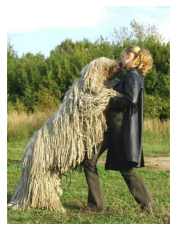

Top 1 Prediction: Class 77 (n02105505-komondor), Confidence: 1.00
Top 2 Prediction: Class 26 (n02092002-scottish_deerhound), Confidence: 0.00
Top 3 Prediction: Class 19 (n02090721-irish_wolfhound), Confidence: 0.00
Top 4 Prediction: Class 9 (n02088094-afghan_hound), Confidence: 0.00


In [40]:
# 샘플 가져오기
pic_num = 20  # 선택할 이미지 인덱스
index = pic_num  # None이면 첫 번째 샘플 가져오기


# Get label names from the dataset info
label_names = ds_info.features['label'].names

try:
    # 데이터셋에서 선택한 이미지 가져오기
    item = get_one_by_index(ds_test, index)
    print(f"Sample Label (True):", item['label'])  # 실제 라벨 출력
    
    # 이미지 시각화
    plt.imshow(item['image'])
    plt.axis('off')
    plt.show()
    
    # 선택한 이미지에 대해 모델 추론 수행
    predictions = infer_class(cam_model, item)  # 상위 4개 클래스 추론
    for i, (class_idx, confidence) in enumerate(predictions):
        label_name = label_names[class_idx]  # 클래스 이름 가져오기
        print(f"Top {i+1} Prediction: Class {class_idx} ({label_name}), Confidence: {confidence:.2f}")

except IndexError as e:
    print(e)


CAM을 생성하기 위해서는 (1) 특성 맵, (2) 클래스별 확률을 얻기 위한 소프트맥스 레이어의 가중치, 그리고 (3) 원하는 클래스의 출력값이 필요합니다. 
또 이미지에서 모델이 어떤 부분을 보는지 직관적으로 확인하려면 네트워크에서 나온 CAM을 입력 이미지 사이즈와 같게 만들어 함께 시각화해야 할 것입니다. 이를 고려해서 model과 item을 받았을 때 입력 이미지와 동일한 크기의 CAM을 반환하는 함수를 만들어야 합니다.

generate_cam() 을 구현하기 위해 아래에서는 conv_ouputs와 같이 특정 레이어의 결과값을 output으로 받기 위해 새로운 모델을 정의하고, feedforward를 거친 후 CAM을 계산하도록 구현하였습니다. 마지막에는 입력 이미지의 크기에 맞춰 CAM을 resize해 주었습니다.

Sample Label: 77


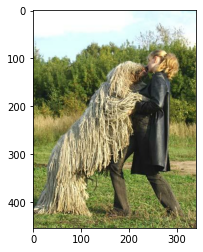

In [41]:
# 샘플 가져오기

index = pic_num  # None이면 첫 번째 샘플 가져오기
try:
    item = get_one_by_index(ds_test, index)
    print(f"Sample Label:", item['label'])
    plt.imshow(item['image'])
    plt.show()
except IndexError as e:
    print(e)

In [42]:
def generate_cam(model, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] 
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

print('슝=3')

슝=3


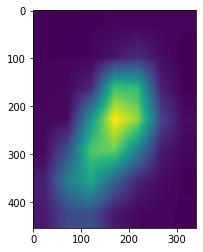

In [43]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

In [44]:
def visualize_cam_on_image(src1, src2, alpha=0.6):
    """
    두 이미지를 가중치를 기반으로 블렌딩하여 합성하는 함수.
    
    Args:
        src1 (numpy.ndarray): 첫 번째 이미지 (예: 원본 이미지).
        src2 (numpy.ndarray): 두 번째 이미지 (예: 클래스 활성화 맵, CAM).
        alpha (float): 첫 번째 이미지(src1)의 가중치. 기본값은 0.5.
    
    Returns:
        numpy.ndarray: 두 이미지를 블렌딩한 합성 이미지.
    """
    # 두 번째 이미지(src2)의 가중치를 계산. 두 가중치의 합이 1.0이 되도록 설정.
     # OpenCV의 addWeighted 함수를 사용해 두 이미지를 블렌딩.
    # src1: 첫 번째 이미지에 가중치 alpha 적용.
    # src2: 두 번째 이미지에 가중치 beta 적용.
    # 마지막 매개변수(0.0)는 블렌딩 결과에 추가할 상수값(기본 0.0).
    beta = (1.0 - alpha)
     
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0)
    
    # 블렌딩된 이미지를 반환.
    return merged_image

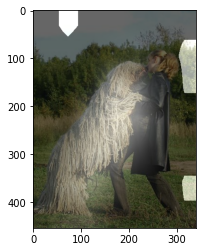

In [45]:
origin_image = item['image'].astype(np.uint8)
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()




8-7. Grad-CAM

Sample Label: 77


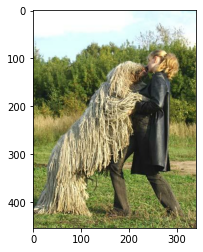

In [46]:
# 샘플 가져오기
index = pic_num  # None이면 첫 번째 샘플 가져오기
try:
    item = get_one_by_index(ds_test, index)
    print(f"Sample Label:", item['label'])
    plt.imshow(item['image'])
    plt.show()
except IndexError as e:
    print(e)

In [47]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다.
        output = conv_output[0] # 원하는 layer의 output을 얻습니다.
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다.
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image

print('슝=3')

슝=3


함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해보세요! 레이어의 이름은 이전 스탭의 cam_model.summary() 결과에서 찾을 수 있음

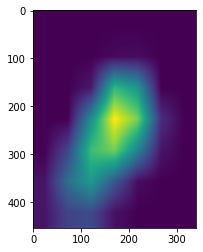

In [48]:
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.show()

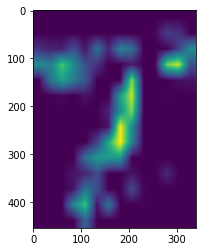

In [49]:
grad_cam_image4 = generate_grad_cam(cam_model, 'conv4_block3_out', item)
plt.imshow(grad_cam_image4)
plt.show()

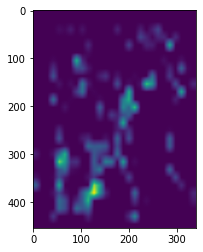

In [50]:
grad_cam_image3 = generate_grad_cam(cam_model, 'conv3_block3_out', item)
plt.imshow(grad_cam_image3)
plt.show()

In [51]:
def overlay_grad_cam_on_image(grad_cam_image, original_image, alpha=0.5):
    """
    Grad-CAM 결과를 원본 이미지 위에 오버레이하는 함수.

    Args:
        grad_cam_image (numpy.ndarray): Grad-CAM 결과 (2D 이미지).
        original_image (numpy.ndarray): 원본 이미지.
        alpha (float): Grad-CAM 결과의 투명도. 기본값은 0.5.

    Returns:
        numpy.ndarray: Grad-CAM이 오버레이된 이미지.
    """
    # Grad-CAM 결과를 3채널로 변환
    grad_cam_colormap = cv2.applyColorMap((grad_cam_image * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # 원본 이미지가 0~1 범위로 정규화되어 있다면 0~255로 변환
    if original_image.max() <= 1.0:
        original_image = (original_image * 255).astype(np.uint8)

    # 원본 이미지와 Grad-CAM 결과를 동일한 크기로 조정
    grad_cam_colormap = cv2.resize(grad_cam_colormap, (original_image.shape[1], original_image.shape[0]))

    # Grad-CAM과 원본 이미지를 블렌딩
    overlayed_image = cv2.addWeighted(grad_cam_colormap, alpha, original_image, 1 - alpha, 0)
    return overlayed_image

print('슝=3')



슝=3


Sample Label: 77


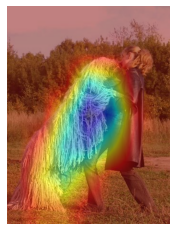

In [52]:
# 샘플 가져오기
index = pic_num  # None이면 첫 번째 샘플 가져오기
try:
    item = get_one_by_index(ds_test, index)
    print(f"Sample Label:", item['label'])

    # Grad-CAM 생성 및 시각화
    grad_cam_num = grad_cam_image5  # model과 레이어 이름 입력 필요
    overlayed_image = overlay_grad_cam_on_image(grad_cam_num, item['image'])

    # 결과 출력
    plt.imshow(overlayed_image)
    plt.axis('off')
    plt.show()
except IndexError as e:
    print(e)


In [91]:
import tensorflow as tf
import numpy as np
import cv2

# Guided Backpropagation 구현
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
    return tf.nn.relu(x), grad

# 모델 레이어에 Guided ReLU 적용
def modify_for_guided_backprop(model):
    for layer in model.layers:
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu
            
            
            
            

# Grad-CAM + Guided Backpropagation (Guided Grad-CAM)
def guided_grad_cam(model, image, target_class_idx, target_layer_name):
    # 모델 복사 및 Guided ReLU 적용
    gb_model = tf.keras.models.clone_model(model)
    modify_for_guided_backprop(gb_model)

    # Grad-CAM 구현
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(target_layer_name).output, model.output]
    )
    
    with tf.GradientTape(persistent=True) as tape:  # persistent=True 추가
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, target_class_idx]
    
    # Gradients 계산
    grads = tape.gradient(loss, conv_outputs)[0]  # Grad-CAM용 Gradient
    guided_grads = tape.gradient(loss, inputs)[0]  # Guided Backpropagation용 Gradient
    del tape  # 메모리 해제

    # Grad-CAM 생성
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(weights * conv_outputs[0], axis=-1)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))  # 수정된 부분
    cam = cam / np.max(cam)

    # Guided Grad-CAM 생성
    guided_cam = guided_grads[0] * cam[..., np.newaxis]
    return guided_cam.numpy()


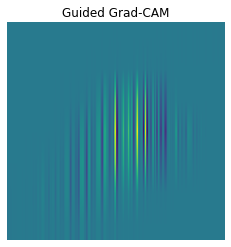

In [93]:

input_image = tf.image.resize(item['image'], [224, 224])
input_image = tf.expand_dims(input_image / 255.0, axis=0)

# Guided Grad-CAM 실행
target_layer = 'conv5_block3_out'  # 마지막 Conv 레이어
target_class = 77  # 클래스 인덱스 (예시)
guided_cam_output = guided_grad_cam(cam_model, input_image, target_class, target_layer)

# 결과 시각화
plt.imshow(np.mean(guided_cam_output, axis=-1), cmap='viridis')
plt.title('Guided Grad-CAM')
plt.axis('off')
plt.show()


In [96]:
import tensorflow as tf
import numpy as np
import cv2

# Guided Backpropagation 구현
@tf.custom_gradient
def guided_relu(x):
    def grad(dy):
        return tf.cast(dy > 0, tf.float32) * tf.cast(x > 0, tf.float32) * dy
    return tf.nn.relu(x), grad

# 모델 레이어에 Guided ReLU 적용
def modify_for_guided_backprop(model):
    for layer in model.layers:
        if hasattr(layer, 'activation') and layer.activation == tf.keras.activations.relu:
            layer.activation = guided_relu

# 모델 복사 및 Guided Backprop 적용
def clone_and_modify_for_guided_backprop(model):
    cloned_model = tf.keras.models.clone_model(model)
    cloned_model.set_weights(model.get_weights())
    modify_for_guided_backprop(cloned_model)
    return cloned_model

# Grad-CAM + Guided Backpropagation (Guided Grad-CAM)
def guided_grad_cam(model, image, target_class_idx, target_layer_name):
    # 모델 복사 및 Guided ReLU 적용
    gb_model = clone_and_modify_for_guided_backprop(model)

    # Grad-CAM 모델 생성
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(target_layer_name).output, model.output]
    )

    with tf.GradientTape(persistent=True) as tape:
        inputs = tf.cast(image, tf.float32)
        tape.watch(inputs)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, target_class_idx]

    # Gradients 계산
    grads = tape.gradient(loss, conv_outputs)[0]
    guided_grads = tape.gradient(loss, inputs)[0]
    del tape  # 메모리 해제

    # Grad-CAM 생성
    weights = tf.reduce_mean(grads, axis=(0, 1))
    cam = tf.reduce_sum(weights * conv_outputs[0], axis=-1)
    cam = np.maximum(cam, 0)
    cam = np.nan_to_num(cam)  # NaN 처리
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))  # 이미지 크기 조정
    cam = cam / np.max(cam)

    # Guided Grad-CAM 생성
    guided_cam = guided_grads[0] * cam[..., np.newaxis]
    return guided_cam.numpy()




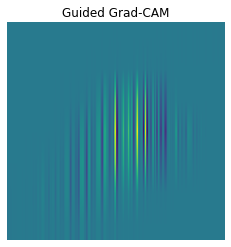

In [97]:
# 입력 이미지 전처리
input_image = tf.image.resize(item['image'], [224, 224])
input_image = tf.expand_dims(input_image / 255.0, axis=0)

# Guided Grad-CAM 실행
target_layer = 'conv5_block3_out'  # 마지막 Conv 레이어
target_class = 77  # 클래스 인덱스 (예시)
guided_cam_output = guided_grad_cam(cam_model, input_image, target_class, target_layer)

# 결과 시각화
import matplotlib.pyplot as plt
plt.imshow(np.mean(guided_cam_output, axis=-1), cmap='viridis')  # 채널 평균 후 시각화
plt.title("Guided Grad-CAM")
plt.axis('off')
plt.show()

In [99]:
import tensorflow as tf

# 모델 경로
model_path = 'history/camtest_model.h5'

# 모델 로드
try:
    cam_model = tf.keras.models.load_model(model_path)
    print(f"모델이 '{model_path}'에서 성공적으로 로드되었습니다.")
    cam_model.summary()  # 모델 구조 출력
except Exception as e:
    print(f"모델 로드 실패: {e}")


모델이 'history/camtest_model.h5'에서 성공적으로 로드되었습니다.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________

In [100]:

# 더미 입력 데이터 생성 (모델에 맞게 224x224x3 사이즈)
dummy_input = np.random.random((1, 224, 224, 3)).astype(np.float32)

# 예측 수행
predictions = cam_model.predict(dummy_input)
print("모델 예측 결과:", predictions)

모델 예측 결과: [[0.00125344 0.00391849 0.00679661 0.00235525 0.00918186 0.00312896
  0.002042   0.02068274 0.00657235 0.00332226 0.00409867 0.00181555
  0.00211319 0.00310084 0.00248173 0.00527065 0.00461791 0.00259424
  0.00446242 0.00246154 0.00724938 0.0044575  0.00180258 0.00039783
  0.00595296 0.00096414 0.00509427 0.00809774 0.01394119 0.01366554
  0.03246742 0.00463941 0.0017675  0.01051521 0.0038347  0.00222416
  0.00458564 0.0024911  0.0331651  0.00137572 0.00565058 0.00272849
  0.00853307 0.00192488 0.00199008 0.00555058 0.00331546 0.00526738
  0.01848532 0.00386324 0.00771442 0.01553853 0.00638365 0.00560661
  0.02150638 0.0061298  0.02979091 0.00380939 0.0241418  0.00973253
  0.0020798  0.00604375 0.03187579 0.00686427 0.00332695 0.00257634
  0.00514333 0.00231133 0.01130316 0.00100572 0.01019538 0.00342876
  0.00164508 0.003598   0.01758008 0.00415453 0.00123265 0.00620013
  0.00238773 0.0407774  0.00065653 0.10002423 0.00656012 0.0032826
  0.00169562 0.02166936 0.00092746 0.00

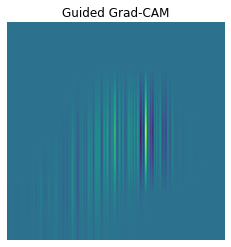

In [106]:
# Grad-CAM 생성 확인
target_layer = 'conv5_block3_out'
target_class = 77  # 예시 클래스 인덱스

# 입력 이미지 전처리
input_image = tf.image.resize(item['image'], [224, 224])  # (224, 224)로 리사이즈
input_image = tf.expand_dims(input_image / 255.0, axis=0)  # 배치 차원 추가 및 정규화

# Grad-CAM 실행
# Grad-CAM 실행 (이미 작성된 코드 사용)
guided_cam_output = guided_grad_cam(cam_model, input_image, target_class, target_layer)

# 시각화
import matplotlib.pyplot as plt
plt.imshow(np.mean(guided_cam_output, axis=-1), cmap='viridis')
plt.title("Guided Grad-CAM")
plt.axis('off')
plt.show()


왜 이럴까..???
고민을 좀 해보자
추후 보완 예정

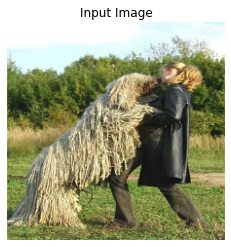

In [94]:
plt.imshow(input_image[0])
plt.title("Input Image")
plt.axis('off')
plt.show()


In [95]:
predictions = cam_model.predict(input_image)
predicted_class = np.argmax(predictions[0])
print(f"Predicted Class: {predicted_class}, Target Class: {target_class}")

Predicted Class: 77, Target Class: 77


### 바운딩 박스만드기

바운딩 박스


Sample Label: 77


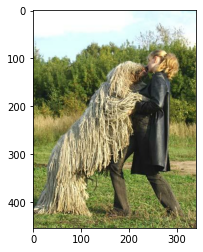

In [53]:
# 샘플 가져오기
index = pic_num  # None이면 첫 번째 샘플 가져오기
try:
    item = get_one_by_index(ds_test, index)
    print(f"Sample Label:", item['label'])
    plt.imshow(item['image'])
    plt.show()
except IndexError as e:
    print(e)

마지막으로 이번에는 CAM에서 물체의 위치를 찾는 detection을 해 보도록 하겠습니다.

우선 새로운 이미지를 다시 뽑아 CAM 이미지를 뽑아봅시다.

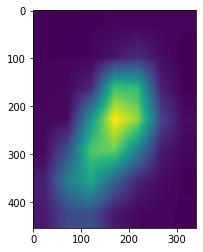

In [54]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)
plt.show()

이전 스텝에서 만들었던 generate_cam()을 활용해서 CAM 이미지를 뽑았습니다. 아래 get_bbox() 함수는 바운딩 박스를 만들기 위해서 score_thresh를 받아 역치값 이하의 바운딩 박스는 없앱니다. 그 다음 OpenCV의 findContours()와 minAreaRect()로 사각형을 찾습니다. 이때 rotated_rect 라는 회전된 바운딩 박스를 얻을 수 있습니다. boxPoints()로 이를 꼭지점으로 바꾸어 줍니다. 마지막에는 int 자료형으로 변환해 줍니다.

In [55]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect

print('슝=3')

슝=3


아래에서 cam_image를 통해 bbox를 얻고 이를 이미지 위에 시각화한 모습을 볼 수 있습니다.

In [56]:
rect1 = get_bbox(cam_image)
rect1

array([[-51, 425],
       [161,  30],
       [366, 141],
       [154, 535]])

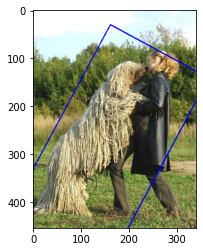

In [57]:
image1 = copy.deepcopy(item['image'])
image1 = cv2.drawContours(image1, [rect1], 0, (0,0,255), 2)
plt.imshow(image1)
plt.show()

grad_cam 이용

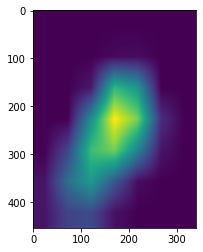

In [58]:
grad_cam_image5 = generate_grad_cam(cam_model, 'conv5_block3_out', item)
plt.imshow(grad_cam_image5)
plt.show()

In [59]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect



print('슝=3')

슝=3


In [60]:
rect2 = get_bbox(grad_cam_image5)
rect2

array([[-39, 433],
       [145,  57],
       [344, 156],
       [159, 531]])

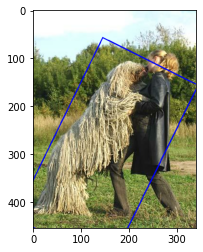

In [61]:
image2 = copy.deepcopy(item['image'])
image2 = cv2.drawContours(image2, [rect2], 0, (0,0,255), 2)
plt.imshow(image2)
plt.show()

In [62]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
#     contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     cnt = contours[0]
#     rotated_rect = cv2.minAreaRect(cnt)
#     rect = cv2.boxPoints(rotated_rect)
#     rect = np.int0(rect)
#     return rect


    # Contours 탐지
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contours found. Check the CAM image or threshold value.")
    
#     # 가장 큰 면적의 컨투어 선택
#     largest_contour = max(contours, key=cv2.contourArea)

#     # 최소 면적 바운딩 박스 계산
#     rotated_rect = cv2.minAreaRect(largest_contour)
#     rect = cv2.boxPoints(rotated_rect)
#     rect = np.int0(rect)

#     return rect
    # 가장 큰 면적의 컨투어 선택
    largest_contour = max(contours, key=cv2.contourArea)

    # x, y 좌표의 최소값과 최대값 계산
    x_min = np.min(largest_contour[:, :, 0])
    x_max = np.max(largest_contour[:, :, 0])
    y_min = np.min(largest_contour[:, :, 1])
    y_max = np.max(largest_contour[:, :, 1])

    # 평균값으로 좌표 보정
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2
    width = (x_max - x_min)
    height = (y_max - y_min)

    # 바운딩 박스 좌표 반환 (평균 기반 직사각형)
    rect = np.array([
        [x_center - width // 2, y_center - height // 2],
        [x_center + width // 2, y_center - height // 2],
        [x_center + width // 2, y_center + height // 2],
        [x_center - width // 2, y_center + height // 2]
    ])
    return np.int0(rect)



print('슝=3')

슝=3


In [63]:
rect3 = get_bbox(grad_cam_image5)
rect3

array([[  0, 100],
       [296, 100],
       [296, 452],
       [  0, 452]])

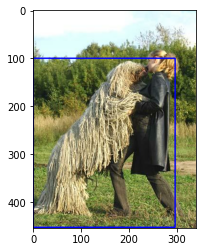

In [64]:
image3 = copy.deepcopy(item['image'])
image3 = cv2.drawContours(image3, [rect3], 0, (0,0,255), 2)
plt.imshow(image3)
plt.show()

Intersection Over Union


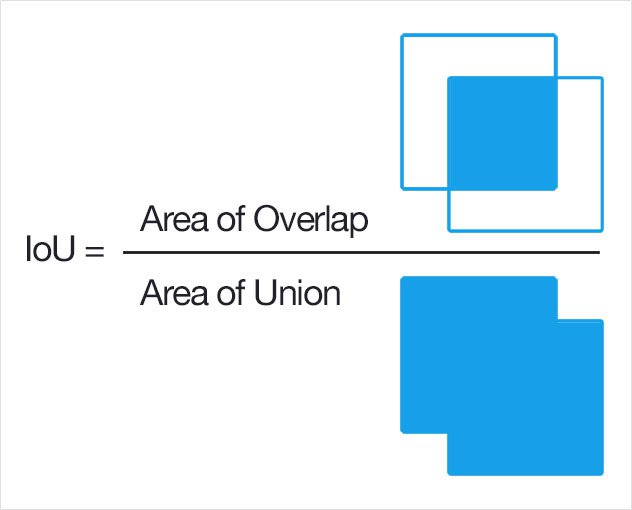

IoU(Intersection over Union) 는 두 영역의 교집합인 intersection 영역의 넓이를 두 영역의 합집합인 union 영역으로 나누어준 값. 
이를 통해 찾고자 하는 물건의 절대적인 면적과 상관없이, 영역을 정확하게 잘 찾아내었는지의 상대적인 비율을 구할 수 있으므로, 모델이 영역을 잘 찾았는지 비교할수 있음

In [65]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox

print('슝=3')

슝=3


위에서 구했던 rect를 minmax bbox 형태로 치환

In [66]:
pred_bbox = rect_to_minmax(rect1, item['image'])
pred_bbox

[0.06607929515418502, -0.15, 1.1784140969162995, 1.076470588235294]

이 데이터의 ground truth bbox를 확인

In [67]:
item['objects']['bbox']

array([[0.23348017, 0.00294118, 0.9493392 , 0.7088235 ]], dtype=float32)

IOU 계산 함수 정의

In [68]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

print('슝=3')

슝=3


### IOU 비교

CAM

In [69]:
get_iou(pred_bbox, item['objects']['bbox'][0])

0.37039675696621827

Grad-CAM

In [70]:
pred_bbox2 = rect_to_minmax(rect2, item['image'])
pred_bbox2

[0.12555066079295155,
 -0.11470588235294117,
 1.169603524229075,
 1.011764705882353]

In [71]:
get_iou(pred_bbox2, item['objects']['bbox'][0])

0.4296526482341885

Grad-CAM(평균값으로 좌표 보정)

In [72]:
pred_bbox3 = rect_to_minmax(rect3, item['image'])
pred_bbox3

[0.22026431718061673, 0.0, 0.9955947136563876, 0.8705882352941177]

In [73]:
get_iou(pred_bbox3, item['objects']['bbox'][0])

0.7486179463464665

추가

In [74]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import copy

def get_one(ds):
    """
    데이터셋에서 첫 번째 샘플을 가져오는 함수.

    Args:
        ds (tf.data.Dataset): TensorFlow 데이터셋.

    Returns:
        dict: 'image', 'label', 'objects' 필드를 포함한 첫 번째 샘플.
    """
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]

def get_one_by_index(ds, index=None):
    """
    데이터셋에서 특정 인덱스의 샘플을 가져오거나, 인덱스를 지정하지 않으면 첫 번째 샘플을 반환.

    Args:
        ds (tf.data.Dataset): TensorFlow 데이터셋.
        index (int, optional): 가져오고자 하는 샘플의 인덱스. None이면 첫 번째 샘플 반환.

    Returns:
        dict: 'image', 'label', 'objects' 필드를 포함한 샘플.
    """
    if index is None:
        return get_one(ds)
    
    sample_data = list(ds.as_numpy_iterator())
    if 0 <= index < len(sample_data):
        bbox = sample_data[index]['objects']['bbox']
        image = sample_data[index]['image']
        label = sample_data[index]['label']
        return sample_data[index]
    else:
        raise IndexError(f"Index {index} is out of range for the dataset.")

def generate_cam(model, item):
    """
    Class Activation Map (CAM)을 생성하는 함수.

    Args:
        model (tf.keras.Model): 학습된 모델.
        item (dict): 'image', 'label' 등을 포함한 샘플 데이터.

    Returns:
        numpy.ndarray: CAM 이미지.
    """
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]

    img_tensor, class_idx = normalize_and_resize_img(item)

    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0))
    conv_outputs = conv_outputs[0, :, :, :]

    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0]

    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, class_idx]):
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image

def infer_class(model, item):
    """
    주어진 이미지 샘플에 대해 모델의 상위 4개 예측 클래스를 추론.

    Args:
        model (tf.keras.Model): 학습된 모델.
        item (dict): 'image', 'label' 등을 포함한 샘플 데이터.

    Returns:
        list: 상위 4개 클래스의 인덱스와 확률.
    """
    img_tensor, _ = normalize_and_resize_img(item)
    predictions = model(tf.expand_dims(img_tensor, 0)).numpy()[0]
    top_indices = predictions.argsort()[-4:][::-1]
    top_confidences = predictions[top_indices]
    return [(int(idx), float(conf)) for idx, conf in zip(top_indices, top_confidences)]

def get_bbox(cam_image, score_thresh=0.05):
    """
    CAM 이미지에서 바운딩 박스를 추출하는 함수.

    Args:
        cam_image (numpy.ndarray): CAM 이미지 (2D 배열).
        score_thresh (float): 임계값. 해당 값 이하의 픽셀은 제거.

    Returns:
        numpy.ndarray: 바운딩 박스의 좌표.
    """
    # 임계값 적용
    low_indices = cam_image <= score_thresh
    cam_image[low_indices] = 0
    cam_image = (cam_image * 255).astype(np.uint8)

    # Contours 탐지
    contours, _ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        raise ValueError("No contours found. Check the CAM image or threshold value.")
    
    # 가장 큰 면적의 컨투어 선택
    largest_contour = max(contours, key=cv2.contourArea)

    # x, y 좌표의 최소값과 최대값 계산
    x_min = np.min(largest_contour[:, :, 0])
    x_max = np.max(largest_contour[:, :, 0])
    y_min = np.min(largest_contour[:, :, 1])
    y_max = np.max(largest_contour[:, :, 1])

    # 평균값으로 좌표 보정
    x_center = (x_min + x_max) // 2
    y_center = (y_min + y_max) // 2
    width = (x_max - x_min)
    height = (y_max - y_min)

    # 바운딩 박스 좌표 반환 (평균 기반 직사각형)
    rect = np.array([
        [x_center - width // 2, y_center - height // 2],
        [x_center + width // 2, y_center - height // 2],
        [x_center + width // 2, y_center + height // 2],
        [x_center - width // 2, y_center + height // 2]
    ])
    return np.int0(rect)

def shuffle_with_fixed_seed(ds, seed=42):
    """
    고정된 시드를 사용해 데이터셋을 셔플.
    Args:
        ds (tf.data.Dataset): 입력 데이터셋.
        seed (int): 셔플에 사용할 시드 값.
    Returns:
        tf.data.Dataset: 고정 시드로 셔플된 데이터셋.
    """
    ds = ds.enumerate()  # 인덱스를 추가
    ds = ds.shuffle(buffer_size=1000, seed=seed)  # 고정된 시드로 셔플
    ds = ds.map(lambda idx, item: item)  # 인덱스를 제거하고 원본 데이터 반환
    return ds

def visualize_layer_activations(model, activations, images_per_row=16):
    """
    모델의 레이어 활성화를 시각화하는 함수.

    Args:
        model (tf.keras.Model): 학습된 모델.
        activations (list): 레이어 활성화 값 리스트.
        images_per_row (int): 한 행에 출력할 이미지 개수.

    Returns:
        None: 활성화 맵을 시각화.
    """
    layer_names = [layer.name for layer in model.layers[:len(activations)]]

    for layer_name, layer_activation in zip(layer_names, activations):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0, :, :, col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size:(col + 1) * size,
                             row * size:(row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title(layer_name)
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')
    plt.show()

print('슝=3')

슝=3


In [79]:
# # 중간 활성화 모델 생성
# layer_outputs = [layer.output for layer in cam_model.layers[:20]]  # 모델의 초기 8개 레이어 선택
# activation_model = tf.keras.models.Model(inputs=cam_model.input, outputs=layer_outputs)

# # 샘플 데이터로부터 활성화 값 계산
# activations = activation_model.predict(item['image'])

# # 활성화 맵 시각화
# visualize_layer_activations(cam_model, activations, images_per_row=16)

ValueError: in user code:

    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.9/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.9/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.9/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.9/site-packages/keras/engine/input_spec.py:266 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) +

    ValueError: Input 0 is incompatible with layer model_13: expected shape=(None, 224, 224, 3), found shape=(None, 340, 3)


In [83]:
print(len(cam_model.layers))


177


In [ ]:
# 첫 번째 샘플 가져오기

# 이미지 리사이즈 및 정규화
input_image = tf.image.resize(item['image'], [224, 224])  # (224, 224)로 리사이즈
input_image = tf.expand_dims(input_image, axis=0)  # 배치 차원 추가
input_image = input_image / 255.0  # 정규화

# 중간 활성화 모델 생성
layer_outputs = [layer.output for layer in cam_model.layers[:175]]  # 모든레이어 출력
activation_model = tf.keras.models.Model(inputs=cam_model.input, outputs=layer_outputs)

# 샘플 데이터로부터 활성화 값 계산
activations = activation_model.predict(input_image)

# 활성화 맵 시각화
visualize_layer_activations(cam_model, activations, images_per_row=16)


용량이 너무 커서 출력은 삭제하였습니다.


추가학습2. Adversarial Complementary Learning을 구현

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers import Adam

# 1. 기존 학습된 모델 (백본) 로드
backbone = load_model('history/camtest_model.h5')
print("백본 모델 로드 완료.")

백본 모델 로드 완료.


In [10]:
backbone.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds

# 이미지 전처리 함수
def normalize_and_resize_img(input):
    """
    이미지 정규화 및 크기 조정 함수.
    Args:
        input (dict): TensorFlow 데이터셋의 샘플 (이미지와 라벨 포함)
    Returns:
        tuple: 정규화된 이미지와 라벨
    """
    image = tf.image.resize(input['image'], [224, 224])  # 이미지 리사이즈
    image = tf.cast(image, tf.float32) / 255.0          # 정규화
    label = input['label']                             # 라벨은 정수 그대로 사용
    return image, label

#  데이터셋 전처리 함수
def preprocess_data(ds, batch_size=16, shuffle=False, seed=42):
    """
    데이터셋에 전처리, 배치 및 prefetch 적용.
    Args:
        ds (tf.data.Dataset): 입력 데이터셋
        batch_size (int): 배치 크기
        shuffle (bool): 셔플 여부
        seed (int): 셔플 시드값
    Returns:
        tf.data.Dataset: 전처리된 데이터셋
    """
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(1000, seed=seed)  # 데이터 셔플
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)  # 배치 및 prefetch 적용
    return ds



In [3]:
# 1. 데이터셋 로드 및 전처리
(ds_train, ds_test), ds_info = tfds.load('stanford_dogs', split=['train', 'test'], with_info=True)

# 학습 및 테스트 데이터셋 준비
batch_size = 16
train_ds = preprocess_data(ds_train, batch_size=batch_size, shuffle=True, seed=42)
test_ds = preprocess_data(ds_test, batch_size=batch_size, shuffle=False)

# 데이터셋 확인
for images, labels in train_ds.take(1):
    print("Batch 이미지 shape:", images.shape)
    print("Batch 라벨 shape:", labels.shape)


Batch 이미지 shape: (16, 224, 224, 3)
Batch 라벨 shape: (16,)


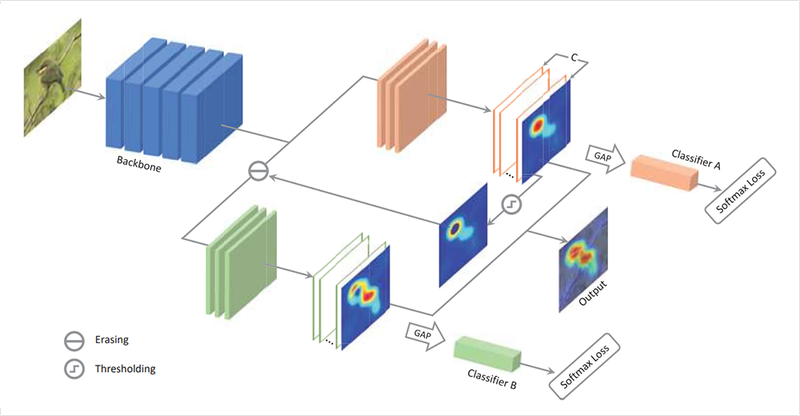

In [55]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from typing import Tuple, Optional

class AdversarialComplementaryLearning:
    def __init__(
        self, 
        backbone_model: Model, 
        num_classes: int, 
        learning_rate: float = 0.001,
        gap_layer_name: str = 'conv5_block3_out'
    ):
        """
        ACL 모델 초기화
        
        Args:
            backbone_model: 사전 학습된 백본 모델
            num_classes: 분류할 클래스 수
            learning_rate: 학습률
            gap_layer_name: 글로벌 평균 풀링 레이어 이름
        """
        self.backbone = backbone_model
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.gap_layer_name = gap_layer_name
        
        # 모델 빌드
        self.primary_model = self._build_classification_model('primary_output')
        self.complementary_model = self._build_classification_model('complementary_output')
        
        # 모델 컴파일
        self._compile_models()

    def _build_classification_model(self, output_name: str) -> Model:
        """
        분류 모델 생성

        Args:
            output_name: 출력 레이어 이름

        Returns:
            분류 모델
        """
        x = self.backbone.output
        output = Dense(
            self.num_classes, 
            activation='softmax', 
            name=output_name
        )(x)
        return Model(inputs=self.backbone.input, outputs=output)

    def _compile_models(self):
        """
        모델 컴파일 및 옵티마이저 설정
        """
        optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        
        self.primary_model.compile(
            optimizer=optimizer, 
            loss=loss, 
            metrics=['accuracy']
        )
        self.complementary_model.compile(
            optimizer=optimizer, 
            loss=loss, 
            metrics=['accuracy']
        )

    def generate_cam(
        self, 
        image: np.ndarray, 
        target_class_idx: int
    ) -> np.ndarray:
        """
        CAM 생성 함수 개선

        Args:
            image: 입력 이미지
            target_class_idx: 관심 클래스 인덱스

        Returns:
            생성된 CAM
        """
        # 이미지 전처리
        image = self._preprocess_image(image)
        
        # 특징 맵 추출 모델 생성
        conv_model = tf.keras.models.Model(
            inputs=self.primary_model.input, 
            outputs=self.primary_model.get_layer(self.gap_layer_name).output
        )
        
        # 특징 맵 추출
        feature_map = conv_model.predict(image)
        
        # 클래스별 가중치 추출
        class_weights = self.primary_model.layers[-1].get_weights()[0]
        
        # CAM 계산
        cam = feature_map[0] * class_weights[target_class_idx].reshape(1, 1, -1)
        cam = np.sum(cam, axis=2)
        
        # 정규화 및 리사이징
        cam = cv2.resize(
            self._normalize_cam(cam), 
            (image.shape[2], image.shape[1])
        )
        
        return cam

    def _preprocess_image(self, image: np.ndarray) -> np.ndarray:
        """
        이미지 전처리 함수

        Args:
            image: 입력 이미지

        Returns:
            전처리된 이미지
        """
        if len(image.shape) == 5:
            image = image[0, 0]
        
        return np.expand_dims(image, axis=0)

    @staticmethod
    def _normalize_cam(cam: np.ndarray) -> np.ndarray:
        """
        CAM 정규화 함수

        Args:
            cam: 입력 CAM

        Returns:
            정규화된 CAM
        """
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam

    def erase_regions(
        self, 
        image: np.ndarray, 
        cam: np.ndarray, 
        threshold: float = 0.5
    ) -> np.ndarray:
        """
        CAM 기반 중요 영역 제거 함수

        Args:
            image: 입력 이미지
            cam: CAM
            threshold: 임계값

        Returns:
            중요 영역이 제거된 이미지
        """
        cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
        mask = (cam > threshold).astype(np.uint8)
        
        erased_image = image.copy()
        erased_image[mask == 1] = 0
        
        return erased_image

    def train_models(
        self, 
        train_dataset: tf.data.Dataset, 
        val_dataset: tf.data.Dataset, 
        epochs: int = 10
    ) -> Tuple[tf.keras.callbacks.History, tf.keras.callbacks.History]:
        """
        모델 학습 통합 메서드

        Args:
            train_dataset: 학습 데이터셋
            val_dataset: 검증 데이터셋
            epochs: 학습 에포크 수

        Returns:
            주 모델과 보완 모델의 학습 이력
        """
        # 주 모델 학습
        print("\n[1] 주 모델 학습 시작...")
        primary_history = self.primary_model.fit(
            train_dataset, 
            validation_data=val_dataset, 
            epochs=epochs
        )
        
        # 보완 모델용 데이터셋 생성
        erased_train_dataset = self._generate_erased_dataset(train_dataset)
        
        # 보완 모델 학습
        print("\n[2] 보완 모델 학습 시작...")
        complementary_history = self.complementary_model.fit(
            erased_train_dataset, 
            validation_data=val_dataset, 
            epochs=epochs
        )
        
        return primary_history, complementary_history

    def _generate_erased_dataset(
        self, 
        dataset: tf.data.Dataset
    ) -> tf.data.Dataset:
        """
        CAM 기반 데이터셋 변형 메서드

        Args:
            dataset: 원본 데이터셋

        Returns:
            변형된 데이터셋
        """
        erased_images, labels = [], []
        
        for data in dataset:
            images, batch_labels = data
            
            for image, label in zip(images, batch_labels):
                # NumPy 배열로 변환
                image_np = image.numpy()
                label_np = label.numpy()
                
                # CAM 생성 및 중요 영역 제거
                cam = self.generate_cam(
                    image=image_np, 
                    target_class_idx=label_np
                )
                
                erased_image = self.erase_regions(
                    image=image_np[0], 
                    cam=cam
                )
                
                erased_images.append(erased_image)
                labels.append(label_np)
        
        # 데이터셋 생성 및 최적화
        return tf.data.Dataset.from_tensor_slices(
            (np.array(erased_images), np.array(labels))
        ).batch(16).prefetch(tf.data.AUTOTUNE)

    def save_models(
        self, 
        primary_path: str = 'primary_model.h5', 
        complementary_path: str = 'complementary_model.h5'
    ):
        """
        모델 저장 메서드

        Args:
            primary_path: 주 모델 저장 경로
            complementary_path: 보완 모델 저장 경로
        """
        self.primary_model.save(primary_path)
        print(f"주 모델이 {primary_path}에 저장되었습니다.")
        
        self.complementary_model.save(complementary_path)
        print(f"보완 모델이 {complementary_path}에 저장되었습니다.")

    @staticmethod
    def load_models(
        primary_path: str = 'primary_model.h5', 
        complementary_path: str = 'complementary_model.h5'
    ) -> Tuple[Model, Model]:
        """
        모델 로드 메서드

        Args:
            primary_path: 주 모델 경로
            complementary_path: 보완 모델 경로

        Returns:
            주 모델과 보완 모델
        """
        primary_model = tf.keras.models.load_model(primary_path)
        complementary_model = tf.keras.models.load_model(complementary_path)
        
        print(f"주 모델이 {primary_path}에서 로드되었습니다.")
        print(f"보완 모델이 {complementary_path}에서 로드되었습니다.")
        
        return primary_model, complementary_model

In [104]:
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense

class AdversarialComplementaryLearning:
    def __init__(self, backbone, num_classes: int, gap_layer_name: str = None):
        """
        ACL 모델 초기화
        Args:
            backbone: 사전 학습된 백본 모델
            num_classes: 분류할 클래스 수 (120)
            gap_layer_name: 글로벌 평균 풀링 레이어 이름 (백본 출력이 바로 사용될 경우 None으로 설정)
        """
        self.backbone = backbone
        self.num_classes = num_classes
        self.gap_layer_name = gap_layer_name or backbone.output.name  # 백본 출력 레이어 사용
        self.primary_model = self._build_classification_model('primary_output')
        self.complementary_model = self._build_classification_model('complementary_output')
        self._compile_models()

    # Dense 레이어 생성 시 입력 크기 수정
    def _build_classification_model(self, output_name: str) -> Model:
        x = self.backbone.output  # ResNet50의 avg_pool 출력
        output = Dense(self.num_classes, activation='softmax', name=output_name)(x)  # 2048 입력 사용
        return Model(inputs=self.backbone.input, outputs=output)

    def _compile_models(self):
        optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)  # SGD 적용
        loss = tf.keras.losses.SparseCategoricalCrossentropy()
        self.primary_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        self.complementary_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    def generate_cam(self, image: np.ndarray, target_class_idx: int) -> np.ndarray:
        """
        CAM 생성
        Args:
            image: 입력 이미지
            target_class_idx: 관심 클래스 인덱스
        Returns:
            CAM (Class Activation Map)
        """
        # Feature Map 추출
        conv_model = Model(inputs=self.primary_model.input, outputs=self.backbone.output)
        feature_map = conv_model.predict(np.expand_dims(image, axis=0))[0]  # (2048,)

        # Dense 레이어 가중치 추출
        class_weights = self.primary_model.layers[-1].get_weights()[0]  # (2048, num_classes)
        target_weights = class_weights[:, target_class_idx]  # (2048,)

        # Feature Map과 가중치 결합
        cam = np.dot(feature_map, target_weights)  # (2048,)

        # ReLU로 활성화
        cam = np.maximum(cam, 0)

        # 정규화 및 예외 처리
        if cam.max() > 0:
            cam = cam / cam.max()
        else:
                print("Warning: CAM의 최대값이 0입니다. 정규화를 건너뜁니다.")
        if cam is None or np.isnan(cam).any():
                print(f"CAM 생성 실패: 클래스 {target_class_idx}")
                return None
        return cam
        

    def print_shapes(self):
        """백본 모델 및 Dense 레이어의 출력 shape 확인"""
        print("Backbone Output Shape:", self.backbone.output.shape)
        print("Dense Layer Weights Shape:", self.primary_model.layers[-1].get_weights()[0].shape)

    def _generate_erased_dataset(self, dataset: tf.data.Dataset) -> tf.data.Dataset:
        erased_images, labels = [], []

        for images, batch_labels in dataset:
            for image, label in zip(images.numpy(), batch_labels.numpy()):
                cam = self.generate_cam(image=image, target_class_idx=label)
                if cam is None:
                    print(f"CAM 생성 실패: 클래스 {label}")
                    continue
                erased_image = self.erase_regions(image=image, cam=cam)
                erased_images.append(erased_image)
                labels.append(label)

        if len(erased_images) == 0 or len(labels) == 0:
            print("Erased dataset 생성 실패: 이미지 또는 레이블이 없습니다.")
            return None

        erased_ds = tf.data.Dataset.from_tensor_slices((np.array(erased_images), np.array(labels))).batch(16).prefetch(tf.data.AUTOTUNE)
        print("Erased dataset 생성 완료.")
        return erased_ds
    
    
    def erase_regions(self, image: np.ndarray, cam: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        중요 영역 제거
        Args:
            image: 입력 이미지
            cam: CAM (Class Activation Map)
            threshold: 임계값
        Returns:
            중요 영역이 제거된 이미지
        """
        mask = (cam > threshold).astype(np.uint8)
        erased_image = image.copy()
        erased_image[mask == 1] = 0
        return erased_image

    def train_primary_model(self, train_dataset: tf.data.Dataset, val_dataset: tf.data.Dataset, epochs: int = 5):
        """
        주 모델 학습
        Args:
            train_dataset: 학습 데이터셋
            val_dataset: 검증 데이터셋
            epochs: 학습 에폭 수
        """
        print("[주 모델] 학습 시작...")
        return self.primary_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)
    

    def train_complementary_model(self, train_dataset: tf.data.Dataset, val_dataset: tf.data.Dataset, epochs: int = 5):
        """
        보완 모델 학습
        Args:
            train_dataset: 학습 데이터셋
            val_dataset: 검증 데이터셋
            epochs: 학습 에폭 수
        """
        print("[보완 모델] 중요 영역 제거 데이터셋 생성 중...")
        erased_train_dataset = self._generate_erased_dataset(train_dataset)
        print("[보완 모델] 학습 시작...")
        return self.complementary_model.fit(erased_train_dataset, validation_data=val_dataset, epochs=epochs)      

In [70]:
for layer in backbone.layers:
    print(layer.name)

input_2
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

In [95]:
# ACL 클래스 생성
acl = AdversarialComplementaryLearning(
    backbone=backbone,
    num_classes=120,
    gap_layer_name='avg_pool'  # 정확한 GAP 레이어 이름 입력
)

# 출력 shape 확인
acl.print_shapes()

Backbone Output Shape: (None, 120)
Dense Layer Weights Shape: (120, 120)


In [105]:
# CAM 생성 테스트
test_image = np.random.rand(224, 224, 3)  # 예제 이미지
cam = acl.generate_cam(image=test_image, target_class_idx=5)
print("CAM 생성 완료")

CAM 생성 완료


In [97]:
acl = AdversarialComplementaryLearning(
    backbone=backbone,
    num_classes=120  # 120개의 클래스
)

In [98]:
# 주 모델 학습 실행
print("주 모델 학습 시작...")
primary_history = acl.train_primary_model(train_ds, test_ds, epochs=1)

주 모델 학습 시작...
[주 모델] 학습 시작...
750/750 [==============================] - 161s 207ms/step - loss: 4.7836 - accuracy: 0.0100 - val_loss: 4.7703 - val_accuracy: 0.0122


In [106]:
# 보완 모델 학습
print("보완 모델 학습 시작...")
complementary_history = acl.train_complementary_model(train_ds, test_ds, epochs=1)

보완 모델 학습 시작...
[보완 모델] 중요 영역 제거 데이터셋 생성 중...
[보완 모델] 학습 시작...


ValueError: Failed to find data adapter that can handle input: <class 'NoneType'>, <class 'NoneType'>

In [28]:
acl = AdversarialComplementaryLearning(backbone_model=backbone, num_classes=120)
acl.compile_models(learning_rate=0.01)



AttributeError: 'AdversarialComplementaryLearning' object has no attribute 'compile_models'

In [11]:
# 데이터셋 준비 (이전 정의된 `train_ds` 및 `test_ds` 사용)
history_primary = acl.train_primary_model(train_ds, test_ds, epochs=1)

# 학습 후 Primary 모델 저장
primary_model_path = 'primary_model_latest.h5'
acl.primary_model.save(primary_model_path)
print(f"Primary 모델이 {primary_model_path}에 저장되었습니다.")



[1] Primary 모델 학습 시작...
750/750 [==============================] - 157s 208ms/step - loss: 4.7469 - accuracy: 0.1188 - val_loss: 4.7337 - val_accuracy: 0.1615


/opt/conda/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Primary 모델이 primary_model_latest.h5에 저장되었습니다.


In [26]:
import cv2

# CAM 기반 중요 영역 제거 후 보완 모델 학습
erased_ds = acl._generate_erased_dataset(train_ds)




ValueError: operands could not be broadcast together with shapes (7,7,2048) (1,1,1920) 

In [ ]:
history_complementary = acl.train_complementary_model(erased_ds, test_ds, epochs=1)

In [ ]:
# CAM 시각화
sample_image, sample_label = next(iter(val_ds.unbatch()))
cam_output = acl.generate_gap_cam(sample_image.numpy(), acl.primary_model, target_class=sample_label)
plt.imshow(sample_image.numpy())
plt.imshow(cam_output, cmap='jet', alpha=0.5)
plt.title("GAP based CAM")
plt.axis('off')

In [8]:
# # 2. CAM 기반 Erasing 함수
# def erase_regions_with_cam(image, cam, threshold=0.5):
#     """
#     활성화 맵을 기반으로 이미지의 중요한 영역 제거
#     Args:
#         image (numpy.ndarray): 입력 이미지
#         cam (numpy.ndarray): CAM 출력
#         threshold (float): 활성화 맵 임계값
#     Returns:
#         numpy.ndarray: 중요한 영역이 제거된 이미지
#     """
#     cam = cv2.resize(cam, (image.shape[1], image.shape[0]))
#     cam = cam / np.max(cam)  # CAM 정규화
#     mask = (cam > threshold).astype(np.uint8)  # 중요 영역 마스크 생성
#     erased_image = image.copy()
#     erased_image[mask == 1] = 0  # 중요 영역을 제거
#     return erased_image

# # 3. ACL 모델 클래스 정의
# class AdversarialComplementaryLearning:
#     def __init__(self, backbone_model, num_classes):
#         """
#         ACL 모델 생성
#         Args:
#             backbone_model: 사전 학습된 백본 모델
#             num_classes: 클래스 개수
#         """
#         self.backbone = backbone_model
#         self.num_classes = num_classes
#         self.primary_model = self._build_primary_model()
#         self.complementary_model = self._build_complementary_model()

#     def _build_primary_model(self):
#         x = self.backbone.output
#         output = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)
#         return tf.keras.models.Model(inputs=self.backbone.input, outputs=output)

#     def _build_complementary_model(self):
#         x = self.backbone.output
#         output = tf.keras.layers.Dense(self.num_classes, activation='softmax')(x)
#         return tf.keras.models.Model(inputs=self.backbone.input, outputs=output)

#     def compile_models(self, learning_rate=0.01):
#         optimizer = tf.keras.optimizers.SGD(learning_rate)
#         self.primary_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         self.complementary_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     def train_models(self, ds_train, ds_val, epochs=5):
#         print("\n[1] Primary 모델 학습 시작...")
#         history_primary = self.primary_model.fit(ds_train, validation_data=ds_val, epochs=epochs)

#         print("\n[2] Complementary 모델 학습 시작...")
#         erased_ds_train = self._generate_erased_dataset(ds_train)
#         history_complementary = self.complementary_model.fit(erased_ds_train, validation_data=ds_val, epochs=epochs)
#         return history_primary, history_complementary

#     def _generate_erased_dataset(self, ds):
#         """
#         주 모델을 사용하여 CAM을 계산하고 중요한 영역을 제거한 데이터를 생성
#         Args:
#             ds (tf.data.Dataset): 원본 데이터셋
#         Returns:
#             tf.data.Dataset: 중요 영역이 제거된 데이터셋
#         """
#         erased_images, labels = [], []
#         for image, label in ds.unbatch().as_numpy_iterator():
#             cam = self._generate_cam(image)
#             erased_image = erase_regions_with_cam(image, cam)
#             erased_images.append(erased_image)
#             labels.append(label)
#         erased_ds = tf.data.Dataset.from_tensor_slices((np.array(erased_images), np.array(labels)))
#         return erased_ds.batch(16).prefetch(tf.data.AUTOTUNE)

#     def _generate_cam(self, image):
#         """
#         Grad-CAM 생성
#         Args:
#             image (numpy.ndarray): 입력 이미지
#         Returns:
#             numpy.ndarray: Grad-CAM 출력
#         """
#         grad_model = tf.keras.models.Model(
#             [self.primary_model.input], [self.primary_model.get_layer('conv5_block3_out').output, self.primary_model.output]
#         )
#         with tf.GradientTape() as tape:
#             inputs = tf.expand_dims(image, axis=0)
#             conv_outputs, predictions = grad_model(inputs)
#             loss = predictions[:, tf.argmax(predictions[0])]
#         grads = tape.gradient(loss, conv_outputs)[0]
#         weights = tf.reduce_mean(grads, axis=(0, 1))
#         cam = tf.reduce_sum(weights * conv_outputs[0], axis=-1)
#         cam = np.maximum(cam, 0)
#         return cam

In [150]:
# # 2. Adversarial Complementary Learning을 위한 네트워크 구성
# class AdversarialComplementaryLearning:
#     def __init__(self, backbone_model, num_classes):
#         """
#         Adversarial Complementary Learning 모델 생성
#         Args:
#             backbone_model: 사전 학습된 백본 모델
#             num_classes: 클래스 개수
#         """
#         self.backbone = backbone_model
#         self.num_classes = num_classes
#         self.primary_model = self._build_primary_model()
#         self.complementary_model = self._build_complementary_model()

#     def _build_primary_model(self):
#         """주 모델을 빌드하는 함수"""
#         x = self.backbone.output  # 백본 출력 레이어 사용
#         output = Dense(self.num_classes, activation='softmax', name='primary_output')(x)
#         return Model(inputs=self.backbone.input, outputs=output, name='primary_model')

#     def _build_complementary_model(self):
#         """보완 모델을 빌드하는 함수"""
#         x = self.backbone.output  # 백본 출력 레이어 사용
#         output = Dense(self.num_classes, activation='softmax', name='complementary_output')(x)
#         return Model(inputs=self.backbone.input, outputs=output, name='complementary_model')


#     def compile_models(self, learning_rate=0.001):
#         """
#         모델 컴파일: 주 모델과 보완 모델을 각각 컴파일
#         """
#         optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
#         self.primary_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#         self.complementary_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#     def train_models(self, ds_train, ds_val, epochs=5):
#         """
#         주 모델과 보완 모델 학습
#         """
#         history_primary = self.primary_model.fit(ds_train, validation_data=ds_val, epochs=epochs)
#         print("\n주 모델 학습 완료.")
#         history_complementary = self.complementary_model.fit(ds_train, validation_data=ds_val, epochs=epochs)
#         print("\n보완 모델 학습 완료.")
#         return history_primary, history_complementary


In [9]:
def save_models(self, primary_path='primary_model.h5', complementary_path='complementary_model.h5'):
        """모델 저장 함수"""
        self.primary_model.save(primary_path)
        print(f"Primary 모델이 {primary_path}에 저장되었습니다.")
        self.complementary_model.save(complementary_path)
        print(f"Complementary 모델이 {complementary_path}에 저장되었습니다.")

@staticmethod
def load_models(primary_path='primary_model.h5', complementary_path='complementary_model.h5'):
    """모델 불러오기 함수"""
    primary_model = tf.keras.models.load_model(primary_path)
    complementary_model = tf.keras.models.load_model(complementary_path)
    print(f"Primary 모델이 {primary_path}에서 불러와졌습니다.")
    print(f"Complementary 모델이 {complementary_path}에서 불러와졌습니다.")
    return primary_model, complementary_model


In [ ]:


# 4. ACL 모델 인스턴스 생성 및 학습
# ACL 인스턴스 생성 및 학습
acl = AdversarialComplementaryLearning(backbone_model=backbone, num_classes=120)
acl.compile_models(learning_rate=0.01)
history_primary, history_complementary = acl.train_models(train_ds, test_ds, epochs=5)

# 모델 저장
acl.save_models(primary_path='primary_model.h5', complementary_path='complementary_model.h5')




[1] Primary 모델 학습 시작...
Epoch 1/5
750/750 [==============================] - 211s 207ms/step - loss: 4.7674 - accuracy: 0.1028 - val_loss: 4.7564 - val_accuracy: 0.1226
Epoch 2/5
750/750 [==============================] - 156s 207ms/step - loss: 4.7068 - accuracy: 0.2892 - val_loss: 4.7132 - val_accuracy: 0.2600
Epoch 3/5
750/750 [==============================] - 156s 207ms/step - loss: 4.6461 - accuracy: 0.4724 - val_loss: 4.6707 - val_accuracy: 0.3889
Epoch 4/5
750/750 [==============================] - 156s 206ms/step - loss: 4.5855 - accuracy: 0.6547 - val_loss: 4.6278 - val_accuracy: 0.5643
Epoch 5/5
750/750 [==============================] - 156s 207ms/step - loss: 4.5251 - accuracy: 0.8725 - val_loss: 4.5850 - val_accuracy: 0.6963

[2] Complementary 모델 학습 시작...


In [ ]:
# 시각화 예시
def visualize_erased_image(image, cam):
    erased_image = erase_regions_with_cam(image, cam)
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(1, 2, 2)
    plt.title("Erased Image")
    plt.imshow(erased_image)
    plt.show()

# 테스트 이미지 시각화
sample_image, _ = next(iter(train_ds.unbatch().take(1)))
cam_output = acl._generate_cam(sample_image.numpy())
visualize_erased_image(sample_image.numpy(), cam_output)


In [ ]:
# 6. CAM 시각화 (선택적 기능)
def visualize_feature_maps(model, sample_image):
    """
    학습된 모델에서 CAM을 기반으로 특성 맵 시각화
    """
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name]
    feature_model = Model(inputs=model.input, outputs=layer_outputs)
    feature_maps = feature_model.predict(sample_image)

    for fmap, layer in zip(feature_maps, [layer.name for layer in model.layers if 'conv' in layer.name]):
        plt.figure(figsize=(15, 10))
        plt.suptitle(layer)
        for i in range(min(16, fmap.shape[-1])):  # 최대 16개의 맵을 시각화
            plt.subplot(4, 4, i+1)
            plt.imshow(fmap[0, :, :, i], cmap='viridis')
            plt.axis('off')
        plt.show()

# 샘플 이미지 CAM 시각화 sample_image, _ = next(iter(train_ds)) visualize_feature_maps(acl.primary_model, sample_image[:1])


In [ ]:
visualize_feature_maps(backbone_model, sample_image)

## 회고

이번 실헝에서  CAM, Grad-CAM, guided Grad-CAM, 바운딩 박스 구하기, IoU 구하기, 레이어별 활성화 채널 시각화, ACL 모델 구현 등을 진행하였습니다.

기본적 실험을 잘 진행되었으나, guided Grad-CAM, ACL 모델 구현 등이 잘 진행되지 않았습니다.

guided Grad-CAM의 결우 레이어의 특징이 잘 추출되었는지 확인이 되지 않고

ACL 모델 같은 경우 텐서 차원의 문제로 erased 이미지가 생성되지 않는 문제가 있었습니다.

이번 실험을 통하여 AI의 결과에 대한 해석가능성을 실습해볼 수 있는 재미있는 시간이었습니다.

In [1]:
!zip history.zip -r history

  adding: history/ (stored 0%)
  adding: history/cam_model.h5 (deflated 8%)
  adding: history/.ipynb_checkpoints/ (stored 0%)
  adding: history/camtest_model.h5 (deflated 8%)
  adding: history/cam_model_new.h5 (deflated 8%)
